In [2]:
import numpy as np
import os
from json_tricks import dump, load
from pydub import AudioSegment, effects
import librosa
import noisereduce as nr
import tensorflow as tf
from keras import models
from keras import layers, callbacks
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
sample_lengths = []
folder_path = '../Dataset'
print(os.path.exists('../Dataset'))
for subdir, dirs, files in os.walk(folder_path):
  for file in files: 
    x, sr = librosa.load(path = os.path.join(subdir,file), sr = None)
    xt, index = librosa.effects.trim(x, top_db=30)
     
    sample_lengths.append(len(xt))

print('Maximum sample length:', np.max(sample_lengths))  

True
Maximum sample length: 204288


In [14]:
# 'emotions' list fix for classification purposes:
#     Classification values start from 0, Thus an 'n = n-1' operation has been executed for both RAVDESS and TESS databases:
def emotion_fix(e_num):
    if e_num == "01":   return 0 # neutral
    elif e_num == "02": return 1 # calm
    elif e_num == "03": return 2 # happy
    elif e_num == "04": return 3 # sad
    elif e_num == "05": return 4 # angry
    elif e_num == "06": return 5 # fear
    elif e_num == "07": return 6 # disgust
    else:               return 7 # surprised

In [16]:
import time
tic = time.perf_counter()

# Initialize data lists
rms = []
zcr = []
mfcc = []
emotions = []

# Initialize variables
total_length = 204288 # desired frame length for all of the audio samples.
frame_length = 2048
hop_length = 512

folder_path = '../Dataset'

for subdir, dirs, files in os.walk(folder_path):
  for file in files:

    # Fetch the sample rate.
      _, sr = librosa.load(path = os.path.join(subdir,file), sr = None) # sr (the sample rate) is used for librosa's MFCCs. '_' is irrelevant.
    # Load the audio file.
      rawsound = AudioSegment.from_file(os.path.join(subdir,file))
    # Normalize the audio to +5.0 dBFS.
      normalizedsound = effects.normalize(rawsound, headroom = 0)
    # Transform the normalized audio to np.array of samples.
      normal_x = np.array(normalizedsound.get_array_of_samples(), dtype = 'float32')
    # Trim silence from the beginning and the end.
      xt, index = librosa.effects.trim(normal_x, top_db=30)
      #print(file,"\t", len(xt), "\t", rawsound.dBFS, "\t", normalizedsound.dBFS) #--QA purposes if needed--
    # Pad for duration equalization.
      if len(xt) > total_length:
        xt = xt[:total_length]  # Trim to match the total length

      padded_x = np.pad(xt, (0, total_length-len(xt)), 'constant')
    # Noise reduction.
      final_x = nr.reduce_noise(padded_x, sr=sr) #updated 03/03/22

   # Features extraction
      f1 = librosa.feature.rms(y=final_x, frame_length=frame_length, hop_length=hop_length) # Energy - Root Mean Square
      f2 = librosa.feature.zero_crossing_rate(final_x , frame_length=frame_length, hop_length=hop_length, center=True) # ZCR
      f3 = librosa.feature.mfcc(y=final_x, sr=sr, n_mfcc=13, hop_length = hop_length) # MFCC

   #RAVDESS database validation
      name = file[6:8]

   # Filling the data lists
      rms.append(f1)
      zcr.append(f2)
      mfcc.append(f3)
      emotions.append(emotion_fix(name))

toc = time.perf_counter()
print(f"Running time: {(toc - tic)/60:0.4f} minutes")

Running time: 2.7761 minutes


In [17]:
f_rms = np.asarray(rms).astype('float32')
f_rms = np.swapaxes(f_rms,1,2)
f_zcr = np.asarray(zcr).astype('float32')
f_zcr = np.swapaxes(f_zcr,1,2)
f_mfccs = np.asarray(mfcc).astype('float32')
f_mfccs = np.swapaxes(f_mfccs,1,2)

print('ZCR shape:',f_zcr.shape)
print('RMS shape:',f_rms.shape)
print('MFCCs shape:',f_mfccs.shape)


ZCR shape: (1200, 400, 1)
RMS shape: (1200, 400, 1)
MFCCs shape: (1200, 400, 13)


In [18]:
# Concatenating all features to 'X' variable.
X = np.concatenate((f_zcr, f_rms, f_mfccs), axis=2)

# Preparing 'Y' as a 2D shaped variable.
Y = np.asarray(emotions).astype('int8')
Y = np.expand_dims(Y, axis=1)

In [19]:
# Save X,Y arrays as lists to json files.

x_data = X.tolist()
x_path = '../X_datanew.json' # FILE SAVE PATH
dump(obj = x_data, fp = x_path)

y_data = Y.tolist()
y_path = '../Y_datanew.json' # FILE SAVE PATH
dump(obj = y_data, fp = y_path)

'[[0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [0], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1], [1]

In [20]:
# Load X,Y json files back into lists, convert to np.arrays

x_path = '../X_datanew.json' # FILE LOAD PATH
X = load(x_path)
X = np.asarray(X, dtype = 'float32')

y_path = '../Y_datanew.json' # FILE LOAD PATH
Y = load(y_path)
Y = np.asarray(Y, dtype = 'int8')

In [21]:
x_train, x_tosplit, y_train, y_tosplit = train_test_split(X, Y, test_size = 0.15, random_state = 1)
x_val, x_test, y_val, y_test = train_test_split(x_tosplit, y_tosplit, test_size = 0.304, random_state = 1)

#'One-hot' vectors for Y: emotion classification
y_train_class = tf.keras.utils.to_categorical(y_train, 8).astype('int8')
y_val_class = tf.keras.utils.to_categorical(y_val, 8).astype('int8')

In [22]:
print(np.shape(x_train))
print(np.shape(x_val))
print(np.shape(x_test))

(1020, 400, 15)
(125, 400, 15)
(55, 400, 15)


In [23]:
# Save x_test, y_test to JSON.

file_path = 'x_test_data.json'
dump(obj = x_test, fp = file_path)

file_path = 'y_test_data.json'
dump(obj = y_test, fp = file_path)

'{"__ndarray__": [[7], [6], [3], [1], [1], [3], [7], [7], [6], [2], [3], [3], [1], [0], [7], [5], [5], [1], [3], [2], [1], [0], [2], [7], [2], [3], [4], [6], [5], [7], [7], [1], [3], [7], [2], [1], [4], [7], [4], [1], [0], [6], [2], [4], [1], [6], [4], [3], [4], [3], [6], [2], [2], [4], [2]], "dtype": "int8", "shape": [55, 1], "Corder": true}'

In [25]:
# Initializing the model

model = models.Sequential()
model.add(layers.LSTM(64, return_sequences = True, input_shape=(X.shape[1:3])))
model.add(layers.LSTM(64))
model.add(layers.Dense(8, activation = 'softmax'))
print(model.summary())

batch_size = 23

# Callbacks functions
checkpoint_path = '../models/best_weights.keras'

#-> Save the best weights
mcp_save = callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True,
                           monitor='val_categorical_accuracy',
                           mode='max')
#-> Reduce learning rate after 100 epoches without improvement.
rlrop = callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy',
                                    factor=0.1, patience=100)

# Compile & train
model.compile(loss='categorical_crossentropy',
                optimizer='RMSProp',
                metrics=['categorical_accuracy'])

history = model.fit(x_train, y_train_class,
                      epochs=200, batch_size = batch_size,
                      validation_data = (x_val, y_val_class),
                      callbacks = [mcp_save, rlrop])
# Define the best weights to the model.
model.load_weights(checkpoint_path)

C:\Users\Aneeta\miniconda3\envs\ser\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 400, 64)        │        20,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,024 (211.03 KB)

 Trainable params: 54,024 (211.03 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 13s 243ms/step - categorical_accuracy: 0.1127 - loss: 2.0994 - val_categorical_accuracy: 0.1120 - val_loss: 2.0651 - learning_rate: 0.0010
Epoch 2/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 231ms/step - categorical_accuracy: 0.1414 - loss: 2.0621 - val_categorical_accuracy: 0.1040 - val_loss: 2.0965 - learning_rate: 0.0010
Epoch 3/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 10s 229ms/step - categorical_accuracy: 0.1606 - loss: 2.0568 - val_categorical_accuracy: 0.1040 - val_loss: 2.1202 - learning_rate: 0.0010
Epoch 4/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 240ms/step - categorical_accuracy: 0.2094 - loss: 2.0209 - val_categorical_accuracy: 0.1920 - val_loss: 1.9759 - learning_rate: 0.0010
Epoch 5/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 204ms/step - categorical_accuracy: 0.1920 - loss: 2.0045 - val_categorical_accuracy: 0.2000 - val_loss: 2.0081 - learning_rate: 0.0010
Epoch 6/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 197ms/step - categorical_accuracy: 0.2147 - loss: 1.9803 - val_c

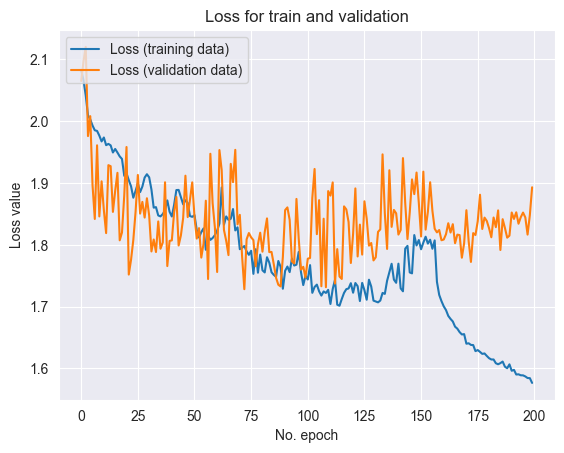

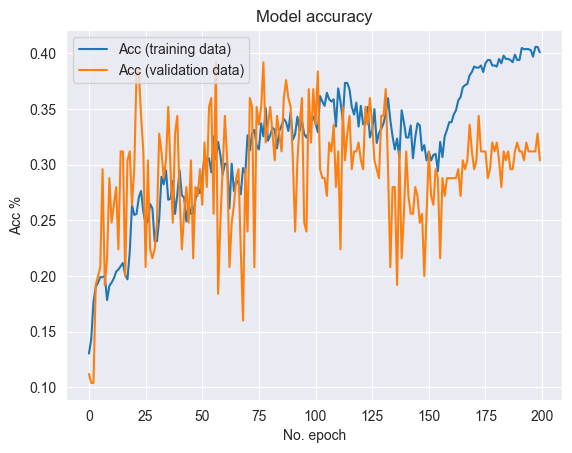

In [26]:
# Loss, Accuracy presentation

# Plot history: Loss
plt.plot(history.history['loss'], label='Loss (training data)')
plt.plot(history.history['val_loss'], label='Loss (validation data)')
plt.title('Loss for train and validation')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

#Plot history: Accuracy
plt.plot(history.history['categorical_accuracy'], label='Acc (training data)')
plt.plot(history.history['val_categorical_accuracy'], label='Acc (validation data)')
plt.title('Model accuracy')
plt.ylabel('Acc %')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [27]:
# Validation score
loss,acc = model.evaluate(x_val, y_val_class, verbose=2)

4/4 - 0s - 102ms/step - categorical_accuracy: 0.3920 - loss: 1.7447


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


Text(0.5, 58.7222222222222, 'Predicted emotion')

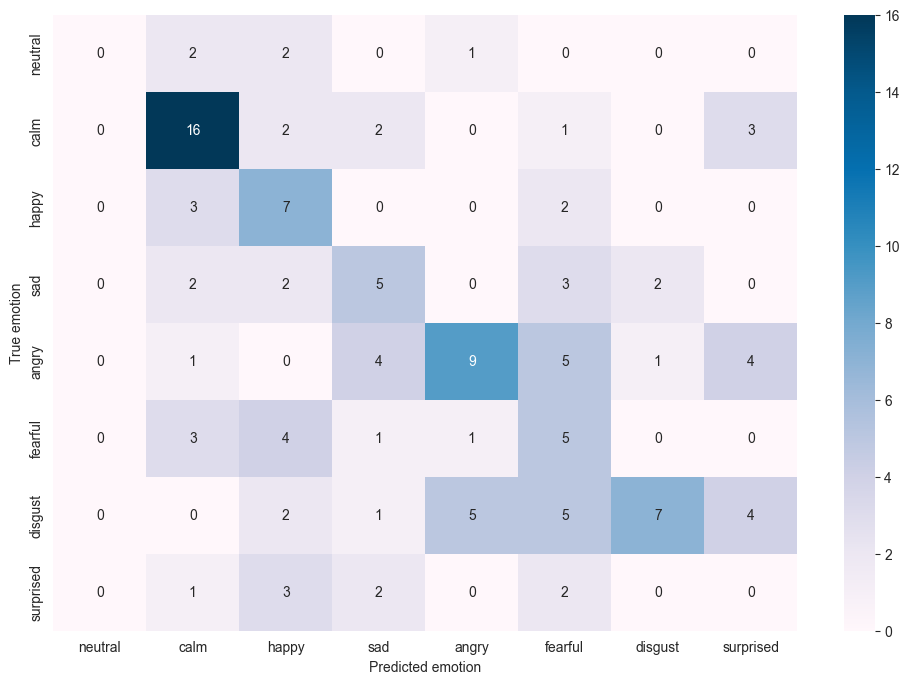

In [29]:
# Validation Confusion matrix
import pandas as pd
y_val_class = np.argmax(y_val_class, axis=1)
predictions = model.predict(x_val)
y_pred_class = np.argmax(predictions, axis=1)

cm=confusion_matrix(y_val_class, y_pred_class)

index = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
columns = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']

cm_df = pd.DataFrame(cm,index,columns)
plt.figure(figsize=(12,8))
ax = plt.axes()

sns.heatmap(cm_df, ax = ax, cmap = 'PuBu', fmt="d", annot=True)
ax.set_ylabel('True emotion')
ax.set_xlabel('Predicted emotion')

In [30]:
# Validation set prediction accuracy rates

values = cm.diagonal()
row_sum = np.sum(cm,axis=1)
acc = values / row_sum

print('Validation set predicted emotions accuracy:')
for e in range(0, len(values)):
    print(index[e],':', f"{(acc[e]):0.4f}")

Validation set predicted emotions accuracy:
neutral : 0.0000
calm : 0.6667
happy : 0.5833
sad : 0.3571
angry : 0.3750
fearful : 0.3571
disgust : 0.2917
surprised : 0.0000


In [32]:
# Saving model & weights

model_json = model.to_json()
saved_model_path = '../models/model8723.json'
saved_weights_path = '../models/model8723_weights.weights.h5'


with open(saved_model_path, "w") as json_file:
    json_file.write(model_json)

model.save_weights(saved_weights_path)
print("Saved model to disk")

Saved model to disk
